In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

Exercise 1:    

Discrete data + probability

Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

Addendeum:   Use something other than request method.

In [3]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [4]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [5]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)

In [6]:
ip_df.head(5)

,ip,ip_count,ip_proba
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,24.26.242.9,21,0.001502


should aggregate by size of data transfer for each IP

need to aggregate by min and max for each IP address

In [7]:
df_ts_size = df['size_mb'].resample('30T').median()

In [8]:
df_ts_size.head()

timestamp
2019-04-16 19:30:00    0.486491
2019-04-16 20:00:00    0.486506
2019-04-16 20:30:00    0.486503
2019-04-16 21:00:00    0.486506
2019-04-16 21:30:00    0.486509
Freq: 30T, Name: size_mb, dtype: float64

In [9]:
idx = pd.date_range(df_ts_size.sort_index().index.min(),df_ts_size.sort_index().index.max(),freq='30min')

In [10]:
df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)

In [11]:
start_date_train = df_ts_size.head(1).index[0]
end_date_train = '2019-04-17 23:30:00'
start_date_test = '2019-04-18 00:00:00'

In [12]:
train = df_ts_size[:end_date_train]
test = df_ts_size[start_date_test:]

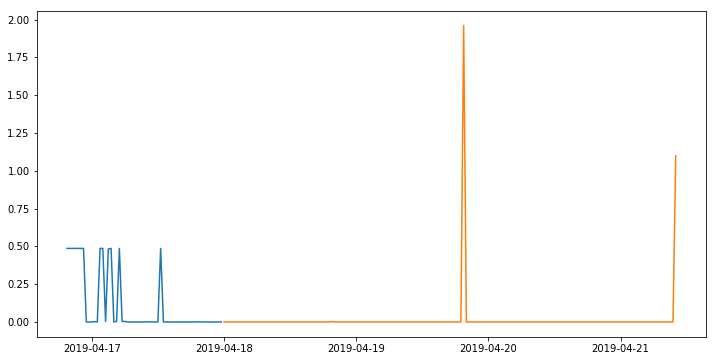

In [13]:
plt.figure(figsize=(12,6))
plt.plot(train)
plt.plot(test)
plt.show()

In [14]:
short_rolling = train.rolling(window=12).mean()

In [15]:
long_rolling = train.rolling(window=24).mean()

Text(0, 0.5, 'Size (MB)')

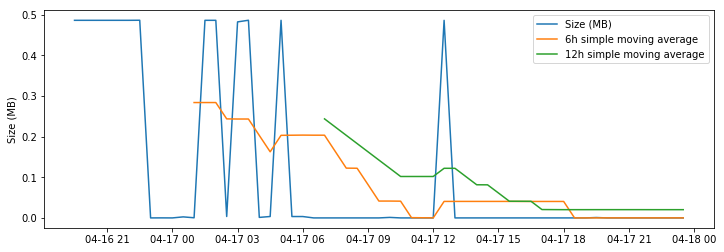

In [16]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(train.index, train, label='Size (MB)')
ax.plot(short_rolling.index, short_rolling, label='6h simple moving average')
ax.plot(long_rolling.index, long_rolling, label='12h simple moving average')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

In [17]:
ema_short = train.ewm(span=12, adjust=False).mean()
ema_short.sample(10)

2019-04-17 07:00:00    0.136724
2019-04-17 14:30:00    0.049563
2019-04-17 13:30:00    0.069224
2019-04-16 20:00:00    0.486494
2019-04-16 19:30:00    0.486491
2019-04-17 23:30:00    0.002489
2019-04-17 08:30:00    0.082831
2019-04-17 01:00:00    0.211428
2019-04-17 18:30:00    0.013024
2019-04-17 11:00:00    0.036068
Name: size_mb, dtype: float64

In [18]:
ema_short.shape

(57,)

In [19]:
ema_long = train.ewm(span=24, adjust=False).mean()
ema_long.sample(10)

2019-04-17 18:30:00    0.046755
2019-04-17 17:00:00    0.060044
2019-04-17 23:00:00    0.022119
2019-04-16 20:00:00    0.486492
2019-04-17 09:00:00    0.158086
2019-04-17 03:30:00    0.344361
2019-04-17 23:30:00    0.020349
2019-04-17 02:00:00    0.346314
2019-04-17 06:30:00    0.239858
2019-04-17 19:00:00    0.043015
Name: size_mb, dtype: float64

Text(0, 0.5, 'Size (MB)')

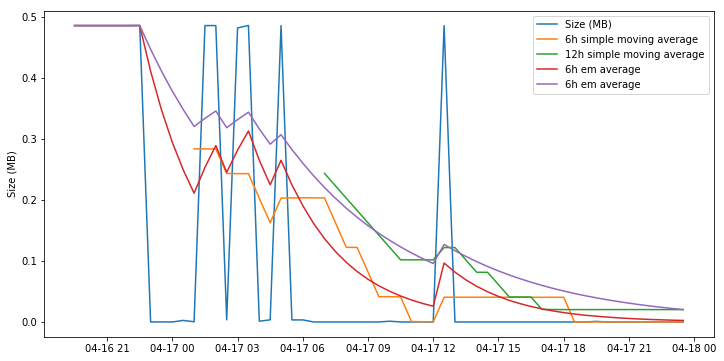

In [20]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train.index, train, label='Size (MB)')

ax.plot(short_rolling.index, short_rolling, label='6h simple moving average')
ax.plot(long_rolling.index, long_rolling, label='12h simple moving average')
ax.plot(ema_short.index, ema_short, label='6h em average')
ax.plot(ema_long.index, ema_long, label='6h em average')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

In [21]:
yhat = pd.DataFrame(dict(actual=test))
yhat['moving_avg_forecast'] = ema_long.iloc[-1]
yhat['moving_avg_forecast'].head()

2019-04-18 00:00:00    0.020349
2019-04-18 00:30:00    0.020349
2019-04-18 01:00:00    0.020349
2019-04-18 01:30:00    0.020349
2019-04-18 02:00:00    0.020349
Freq: 30T, Name: moving_avg_forecast, dtype: float64

In [22]:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)
yhat.head()

,actual,moving_avg_forecast,error
2019-04-18 00:00:00,0.0,0.020349,0.020349
2019-04-18 00:30:00,0.0,0.020349,0.020349
2019-04-18 01:00:00,0.0,0.020349,0.020349
2019-04-18 01:30:00,0.0,0.020349,0.020349
2019-04-18 02:00:00,0.0,0.020349,0.020349


In [23]:
q1 = yhat.error.describe().loc['25%']
q3 = yhat.error.describe().loc['75%']
yhat.describe()

,actual,moving_avg_forecast,error
count,165.000000,1.650000e+02,165.000000
mean,0.018564,2.034939e-02,0.038391
std,0.174573,5.220013e-17,0.170282
min,0.000000,2.034939e-02,0.017908
25%,0.000000,2.034939e-02,0.020349
50%,0.000000,2.034939e-02,0.020349
75%,0.000000,2.034939e-02,0.020349
max,1.961066,2.034939e-02,1.940717


In [24]:

span = 24
ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

In [25]:
ub,  lb

(0.11662591274966773, -0.07592712496220251)

calculate percent_b,   

In [26]:
yhat['pct_b'] = (yhat.actual-lb/ (ub-lb))

In [27]:
# print anomalies
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2019-04-19 19:30:00,1.961066,0.020349,1.940717,2.355384
2019-04-21 10:00:00,1.099591,0.020349,1.079242,1.493909


Exercise 2

Time series + EMA

Pick a specific cohort
Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.


In [48]:
colnames=['date', 'timestamp', 'webpage', 'user_id', 'cohort',
          'ip_addr']
df = pd.read_csv('anonymized-curriculum-access.txt',          
                 engine='python',
                 index_col='date',
#                 skiprows=[0],            
                 header=None,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 1, 2, 3, 4, 5]
)

make the staff cohort (currently Nan) be Zero
create a date time index (combine date time stamp)

In [49]:
df.sample(5)

,timestamp,webpage,user_id,cohort,ip_addr
date,,,,,
2018-04-05,13:58:41,java-iii/finish-the-adlister,35,22.0,97.105.19.61
2018-10-20,19:12:11,spring/setup,195,24.0,104.53.202.214
2018-12-19,16:34:41,javascript-i/bom-and-dom/dom-events,261,26.0,97.105.19.58
2018-08-20,20:22:20,content/javascript/conditionals.html,80,14.0,136.50.29.193
2018-06-04,12:20:11,java-i/console-io,25,23.0,97.105.19.61


In [50]:
df.reset_index(inplace=True)

Build a user_df dataframe that has the earliest starting day and most recent ending day of web access,  use those dates to get the duration of time hitting on the website - then merge it back into the df dataframe
Have to reset the index first (because 'date" is the index and is not accessible otherwise)

Aggregate on the minimum date and maximum date for each user


In [51]:
user_df = df[['user_id','date']].copy()
user_df = user_df.groupby('user_id').agg(['min','max'])

In [52]:
# The min data and max date will be on split levels (use user_df.head() to see this,   
# you can't directly manipulate those columns - so you have to "droplevel".  
# Once you do that you can access the columns as min and max.  
user_df.columns = user_df.columns.droplevel()

In [53]:
# after using the agg method,  the results will be strings, not dates,  so convert to datetime,
#  then subtract and create the new column called duration, drop min and max because they are redundant

user_df['startdate'] = pd.to_datetime(user_df['min'], format='%Y-%m-%d')
user_df['enddate'] = pd.to_datetime(user_df['max'], format='%Y-%m-%d')
user_df['duration'] = user_df.enddate - user_df.startdate
user_df.drop(['min','max'], axis=1, inplace=True)


In [54]:
logins_df = df[['user_id','date','timestamp','webpage']].copy()
logins_df = logins_df.groupby('user_id').agg({"timestamp": "count"})
logins_df = logins_df.rename(columns={'timestamp': 'logins'})


In [112]:
day_df = df[['date','cohort','user_id']].copy()


In [115]:
day_df.head()

,date,cohort,user_id
0,2018-01-26,8.0,1
1,2018-01-26,8.0,1
2,2018-01-26,8.0,1
3,2018-01-26,8.0,1
4,2018-01-26,22.0,2


In [120]:
day_df[['cohort' == 7 ]].groupby(['date','user_id']).agg({'user_id': 'count'}).rename(columns={'user_id': 'count'})

count
date       user_id       
2018-01-26 1            7
           2           17
           3           22
           4           14
           5           14
           6           21
           7           35
           8            2
           9            2
           10          31
           11          19
           12          10
           13          15
           14           3
           15          32
           16           7
           17           6
           18          15
           19          67
           20           8
           21           2
           22           3
           23          12
           24           2
           25           5
           26           3
           27           9
           28          14
           29           5
           30          15
...                   ...
2019-04-02 361          1
           362          1
           363          1
           364          2
           366          1
           367          3
           368          3
           369          1
           372          1
           373          9
           374          6
           375         11
           376          9
           377         11
           379         16
           380         12
           381          5
           382          8
           383          9
           384          9
           385          3
           386          7
           387         10
           389          6
           390          6
           392         10
           393         26
           394          5
           395         28
           397          1

[18485 rows x 1 columns]

In [118]:
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233528 entries, 0 to 233527
Data columns (total 3 columns):
date       233528 non-null object
cohort     219070 non-null float64
user_id    233528 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.3+ MB


In [119]:
day_df.head()

,date,cohort,user_id
0,2018-01-26,8.0,1
1,2018-01-26,8.0,1
2,2018-01-26,8.0,1
3,2018-01-26,8.0,1
4,2018-01-26,22.0,2


In [46]:
logins_df.head()

,logins
user_id,
1,2639
2,1541
3,1560
4,692
5,1701


In [35]:
user_df.head()

,startdate,enddate,duration
user_id,,,
1,2018-01-26,2019-04-02,431 days
2,2018-01-26,2018-05-10,104 days
3,2018-01-26,2019-01-09,348 days
4,2018-01-26,2018-03-27,60 days
5,2018-01-26,2018-07-19,174 days


merge logins_df and user_df on user_id to new dataframe (user_logins)  - make sure same number of rows

In [36]:
user_logins = pd.merge(user_df, logins_df, on='user_id')

now merge user_logins to df , use a left join so we don't lose individual log in times 

In [37]:
df = pd.merge(df, user_df, how='left', on='user_id')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['hour'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S').dt.hour
df.fillna(0, inplace=True)
df.rename(columns={'startdate_x': 'startdate','enddate_x': 'enddate','duration_x': 'duration'}, inplace=True)
df.drop(['timestamp'], axis=1, inplace=True)
# df.drop(['startdate_y','enddate_y','duration_y'], axis=1, inplace=True)
df = df[['date','user_id','hour','cohort','webpage','ip_addr','startdate','duration','enddate']]
df.duration = df.duration.astype('timedelta64[D]').astype(int)
df = df.set_index('date')

In [38]:
df.sample(10)

,user_id,hour,cohort,webpage,ip_addr,startdate,duration,enddate
date,,,,,,,,
2018-06-05,1,8,8.0,java-iii/jdbc,97.105.19.61,2018-01-26,431,2019-04-02
2019-01-07,11,14,28.0,spring/fundamentals/form-model-binding,97.105.19.58,2018-01-26,431,2019-04-02
2018-04-01,83,22,18.0,spring/fundamentals/relationships,45.21.0.138,2018-02-03,313,2018-12-13
2018-11-07,294,10,27.0,html-css,97.105.19.58,2018-11-05,142,2019-03-27
2018-03-08,99,10,22.0,slides/collections,97.105.19.61,2018-02-12,339,2019-01-17
2018-08-16,207,15,24.0,mysql/users,97.105.19.58,2018-05-29,99,2018-09-05
2018-04-10,135,19,23.0,mkdocs/search_index.json,99.158.247.126,2018-03-05,151,2018-08-03
2019-03-10,339,9,29.0,java-ii/annotations,67.11.28.235,2019-01-22,70,2019-04-02
2018-08-14,199,22,24.0,mysql,99.158.247.252,2018-05-29,100,2018-09-06


In [39]:
# user id looks scrambled,  or  our cohort isn't in the log yet
# gary_df = df.loc[df['user_id'] == 673]
# cohort22_df = df.loc[df['cohort'] == 22]
# business_hours = df.loc[(df['hour'] >= 7) & (df['hour'] <= 18)]


Now df is the original dataframe, date is back in datetime format (unsetting the index turned into string), plus columns for startdate, enddate, duration


Go ahead with rest of lesson on time anomalies

Need to come back to adding to the dataframe later,   add columns that allow subsets to be pulled out by
1) weekday versus weekend
2) after hours versus business hours
3) total number of logins per user
4) number of different Ip addrs
5) curriculum
6) distance to login ip_addr (will need lat/long info for this one)
7) Cohort name

In [40]:
business_hours = df.loc[(df['hour'] >= 20)]

In [41]:
cohort22_df = df.loc[df['cohort'] == 22]

there are 5 users who have been accessing the website for more that 425 days
user_id = 1     #  datascience and webdev, probably Maggie
user_id = 11    #  datascience and webdev, maybe Zach
user_id = 36    #  looks like webdev only
user_id = 48    # .  admin,   maybe Dmitri
user_id = 41    #  Ryan? 
   
need to figure out where (what pages) most of these spend their time   

In [42]:
extended_users = df.loc[(df.duration >= 425)]

In [43]:
extended_users.user_id.nunique()

5

In [44]:
# inst_df = df.loc[df['user_id'] == 41]
# sorted(inst_df['webpage'].unique())

next - need to aggregate by user_id and date to get count . (number of accesses per day), merge this into user_df

In [45]:
#  use cohort 22 as the test base
# adjust=False specifies that we are interested in the 
# recursive calculation mode.


# ema_short = train.ewm(span=7, adjust=False).mean()
# ema_short[0:3]

# ema_long = train.ewm(span=span, adjust=False).mean()
# ema_long[0:3]

